# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from skynet.utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = '../skynet/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = list(range(num_training, num_training + num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **linear/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from skynet.linear.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001 # D x C
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.369651
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*

By randomly initializing the weights, the prediction results for each class tend to be of equal probability. And there are 10 classes, meaning each has a probability of 1/10.


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from skynet.utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.794679 analytic: 1.794679, relative error: 2.501120e-09
numerical: -2.047843 analytic: -2.047843, relative error: 1.510634e-08
numerical: -1.338093 analytic: -1.338093, relative error: 9.466247e-09
numerical: 1.540616 analytic: 1.540616, relative error: 3.458885e-08
numerical: 0.275297 analytic: 0.275297, relative error: 1.135912e-07
numerical: -5.975292 analytic: -5.975292, relative error: 7.047495e-10
numerical: -3.156706 analytic: -3.156706, relative error: 1.598705e-08
numerical: 1.332692 analytic: 1.332692, relative error: 7.460575e-08
numerical: -1.749183 analytic: -1.749183, relative error: 1.117724e-09
numerical: -0.445788 analytic: -0.445788, relative error: 1.361485e-09
numerical: 0.793491 analytic: 0.793491, relative error: 9.097127e-08
numerical: 1.853737 analytic: 1.853737, relative error: 1.621229e-08
numerical: -0.744759 analytic: -0.744759, relative error: 1.391429e-07
numerical: 2.756890 analytic: 2.756890, relative error: 8.666795e-09
numerical: 0.867358 

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from skynet.linear.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.369651e+00 computed in 0.085196s
vectorized loss: 2.369651e+00 computed in 0.004321s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from skynet.linear import Softmax
results = {}
best_val = -1
best_softmax = None
# Grid search
# learning_rates = [1e-7, 3e-7, 5e-7, 7e-7, 1e-6, 3e-6]
# regularization_strengths = [1e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3]
# learning_rates = np.logspace(-7, -6, 5)
# regularization_strengths = np.logspace(3, 4, 5)

# Random search
learning_rates = sorted(10**np.random.uniform(-7, -5, 6))
regularization_strengths = sorted(10**np.random.uniform(3, 4, 6))
# regularization_strengths = sorted(10**np.random.uniform(4, 4.2, 6))

# best hyperparameters found for classification performance with 
# accuracy: 0.407020, 0.404000, 0.394000
# learning_rates = [9.740577e-07]
# regularization_strengths = [1.469906e+03]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        classifier = Softmax()
        classifier.train(X_train, y_train, 
                         learning_rate=learning_rate, reg=reg, num_iters=1500,
                         batch_size=200, verbose=False)
        y_train_predict = classifier.predict(X_train)
        y_val_predict = classifier.predict(X_val)
        train_accuracy = np.mean(y_train==y_train_predict)
        val_accuracy = np.mean(y_val==y_val_predict)
        results[(learning_rate, reg,)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = classifier
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
            learning_rate, reg, train_accuracy, val_accuracy))
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.322013e-07 reg 1.019761e+03 train accuracy: 0.301265 val accuracy: 0.316000
lr 2.322013e-07 reg 1.324964e+03 train accuracy: 0.315959 val accuracy: 0.310000
lr 2.322013e-07 reg 1.796276e+03 train accuracy: 0.326531 val accuracy: 0.337000
lr 2.322013e-07 reg 2.862885e+03 train accuracy: 0.347061 val accuracy: 0.367000
lr 2.322013e-07 reg 4.230012e+03 train accuracy: 0.362204 val accuracy: 0.379000
lr 2.322013e-07 reg 5.227460e+03 train accuracy: 0.375286 val accuracy: 0.390000
lr 4.016129e-07 reg 1.019761e+03 train accuracy: 0.350694 val accuracy: 0.361000
lr 4.016129e-07 reg 1.324964e+03 train accuracy: 0.358347 val accuracy: 0.362000
lr 4.016129e-07 reg 1.796276e+03 train accuracy: 0.372286 val accuracy: 0.372000
lr 4.016129e-07 reg 2.862885e+03 train accuracy: 0.383878 val accuracy: 0.387000
lr 4.016129e-07 reg 4.230012e+03 train accuracy: 0.389755 val accuracy: 0.396000
lr 4.016129e-07 reg 5.227460e+03 train accuracy: 0.382755 val accuracy: 0.392000
lr 6.378143e-07 reg 1.019761

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.370000


In [8]:
def visualize_weights(weights):
    """
    Visualize the learned weights for each class
    """
#     w = weights[:-1,:] # strip out the bias
    w = weights
    w = w.reshape(32, 32, 3, 10)

    w_min, w_max = np.min(w), np.max(w)

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
      plt.subplot(2, 5, i + 1)
  
      # Rescale the weights to be between 0 and 255
      wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
      plt.imshow(wimg.astype('uint8'))
      plt.axis('off')
      plt.title(classes[i])

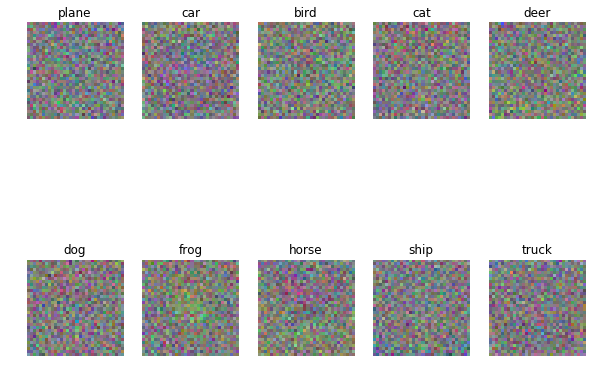

In [9]:
# Visualize the learned weights for each class
visualize_weights(best_softmax.W[:-1,:])

The learned weights for each class in softmax model resembles the shape of each class' object. The larger the regularization strength is, the more the weights are shrinked, giving less noise in the visualized image and making it more clear. 

lr 4.019744e-07 reg 1.130442e+04 train accuracy: 0.369469 val accuracy: 0.383000


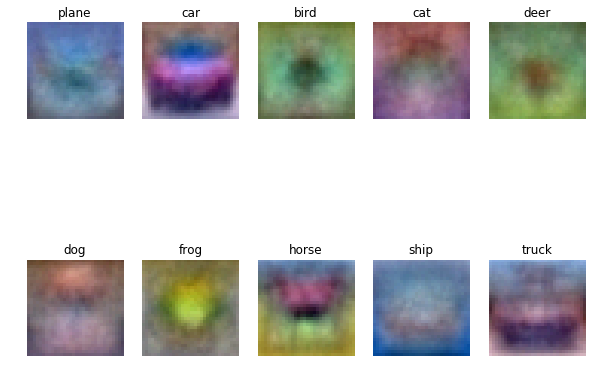

In [10]:
# this will produce weights more similar to the class images
learning_rates = [4.019744e-07]
regularization_strengths = [1.130442e+04]
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        classifier = Softmax()
        classifier.train(X_train, y_train, 
                         learning_rate=learning_rate, reg=reg, num_iters=1500,
                         batch_size=200, verbose=False)
        y_train_predict = classifier.predict(X_train)
        y_val_predict = classifier.predict(X_val)
        train_accuracy = np.mean(y_train==y_train_predict)
        val_accuracy = np.mean(y_val==y_val_predict)
        results[(learning_rate, reg,)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = classifier
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
            learning_rate, reg, train_accuracy, val_accuracy))
  
visualize_weights(classifier.W[:-1,:])
